# **Modelo ResNet50**
# **Adrian Pineda Sanchez A00834710**

# **Por medio del tutorial basado en: Fashion-MNIST-by-ResNet-50.ipynb**



# **MODELO COMPARATIVO CON ResNet**

# Se realizaron modificaciones en todos los hiperparametros y la arquitectectura pero el modelo sigue manteniendo su integridad

In [1]:
!pip install tensorflow-gpu==2.0.0-alpha0

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0-alpha0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0-alpha0


## **Preparacion de los datos**

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

#print(tfds.list_builders())
dataset, info = tfds.load('fashion_mnist', as_supervised = True, with_info = True)
dataset_test, dataset_train = dataset['test'], dataset['train']
print(info)

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_dir='/root/tensorflow_datasets/fashion_mnist/3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    =

In [3]:
def convert_types(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

batch_size = 64

dataset_train = dataset_train.map(convert_types).shuffle(10000).batch(batch_size)
dataset_test = dataset_test.map(convert_types).batch(batch_size)

## **Data Augmentation**

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#datagen = ImageDataGenerator()
datagen = ImageDataGenerator(rotation_range = 10, horizontal_flip = True, zoom_range = 0.1)

# **Definicion del modelo ResNet50**

In [5]:
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, MaxPool2D, GlobalAveragePooling2D, Add
from tensorflow.keras import Model

class ResidualBlock(Model):
    def __init__(self, channel_in = 64, channel_out = 256):
        super().__init__()

        channel = channel_out // 4

        self.conv1 = Conv2D(channel, kernel_size = (1, 1), padding = "same")
        self.bn1 = BatchNormalization()
        self.av1 = Activation(tf.nn.relu)
        self.conv2 = Conv2D(channel, kernel_size = (3, 3), padding = "same")
        self.bn2 = BatchNormalization()
        self.av2 = Activation(tf.nn.relu)
        self.conv3 = Conv2D(channel_out, kernel_size = (1, 1), padding = "same")
        self.bn3 = BatchNormalization()
        self.shortcut = self._shortcut(channel_in, channel_out)
        self.add = Add()
        self.av3 = Activation(tf.nn.relu)

    def call(self, x):
        h = self.conv1(x)
        h = self.bn1(h)
        h = self.av1(h)
        h = self.conv2(h)
        h = self.bn2(h)
        h = self.av2(h)
        h = self.conv3(h)
        h = self.bn3(h)
        shortcut = self.shortcut(x)
        h = self.add([h, shortcut])
        y = self.av3(h)
        return y

    def _shortcut(self, channel_in, channel_out):
        if channel_in == channel_out:
            return lambda x : x
        else:
            return self._projection(channel_out)

    def _projection(self, channel_out):
        return Conv2D(channel_out, kernel_size = (1, 1), padding = "same")

class ResNet50(Model):
    def __init__(self, input_shape, output_dim):
        super().__init__()

        self._layers = [
            Conv2D(64, input_shape=input_shape, kernel_size=(7, 7), strides=(2, 2), padding="same"),
            BatchNormalization(),
            Activation(tf.nn.relu),
            MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding="same"),
            # Reducir el número de bloques residuales para disminuir la complejidad del modelo
            ResidualBlock(64, 256),
            [
                ResidualBlock(256, 256) for _ in range(1)  # Reducido a 1 bloque residua
            ],
            Conv2D(512, kernel_size=(1, 1), strides=(2, 2)),
            [
                ResidualBlock(512, 512) for _ in range(2)
            ],
            Conv2D(1024, kernel_size=(1, 1), strides=(2, 2)),
            [
                ResidualBlock(1024, 1024) for _ in range(3)
            ],
            Conv2D(2048, kernel_size=(1, 1), strides=(2, 2)),
            [
                ResidualBlock(2048, 2048) for _ in range(2)  # Reducido a 2 bloques residuales
            ],
            GlobalAveragePooling2D(),
            Dense(1000, activation=tf.nn.relu),
            Dense(output_dim, activation=tf.nn.softmax)
        ]

    def call(self, x):
        for layer in self._layers:
            if isinstance(layer, list):
                for l in layer:
                    x = l(x)
            else:
                x = layer(x)
        return x


model = ResNet50((28, 28, 1), 10)
model.build(input_shape = (None, 28, 28, 1))
model.summary()

Model: "res_net50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  3200      
                                                                 
 batch_normalization (Batch  multiple                  256       
 Normalization)                                                  
                                                                 
 activation (Activation)     multiple                  0         
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 residual_block (ResidualBl  multiple                  75904     
 ock)                                                            
                                                         

In [6]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
#optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1, momentum = 0.9, decay =  0.0001)

# **Preparacion de Entrenamiento**

In [7]:
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'test_accuracy')

In [8]:
@tf.function
def train_step(image, label):
    with tf.GradientTape() as tape:
        predictions = model(image)
        loss = loss_object(label, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(label, predictions)

@tf.function
def test_step(image, label):
    predictions = model(image)
    loss = loss_object(label, predictions)

    test_loss(loss)
    test_accuracy(label, predictions)

## **Entrenamiento**

In [11]:
import time

num_epoch = 10
start_time = time.time()

train_accuracies = []
test_accuracies = []

for epoch in range(num_epoch):
    for image, label in dataset_train:
        for _image, _label in datagen.flow(image, label, batch_size = batch_size):
            train_step(_image, _label)
            break

    for test_image, test_label in dataset_test:
        test_step(test_image, test_label)

    train_accuracies.append(train_accuracy.result())
    test_accuracies.append(test_accuracy.result())

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}, spent_time: {} min'
    spent_time = time.time() - start_time
    print(template.format(epoch + 1, train_loss.result(), train_accuracy.result() * 100, test_loss.result(), test_accuracy.result() * 100, spent_time / 60))

Epoch 1, Loss: 0.4720892310142517, Accuracy: 82.25167083740234, Test Loss: 0.42129114270210266, Test Accuracy: 84.5133285522461, spent_time: 0.6017534653345744 min
Epoch 2, Loss: 0.45608431100845337, Accuracy: 82.87309265136719, Test Loss: 0.41332200169563293, Test Accuracy: 84.74285888671875, spent_time: 1.1072658856709798 min
Epoch 3, Loss: 0.4425831735134125, Accuracy: 83.38812255859375, Test Loss: 0.4051825702190399, Test Accuracy: 85.11499786376953, spent_time: 1.631849229335785 min
Epoch 4, Loss: 0.43132296204566956, Accuracy: 83.81555938720703, Test Loss: 0.3967975974082947, Test Accuracy: 85.44889068603516, spent_time: 2.18688542842865 min
Epoch 5, Loss: 0.42087769508361816, Accuracy: 84.22383117675781, Test Loss: 0.39033618569374084, Test Accuracy: 85.79199981689453, spent_time: 2.6919002532958984 min
Epoch 6, Loss: 0.41194865107536316, Accuracy: 84.56121063232422, Test Loss: 0.38420426845550537, Test Accuracy: 86.02091217041016, spent_time: 3.1983030080795287 min
Epoch 7, Los

## **Train y Test Accurary**

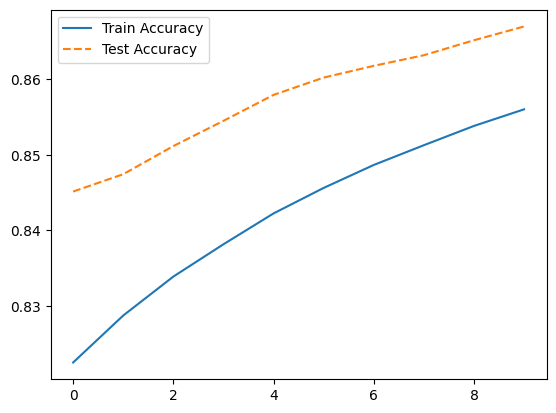

In [12]:
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label = 'Train Accuracy')
plt.plot(test_accuracies, linestyle = 'dashed', label = 'Test Accuracy')
plt.legend()
plt.show()